Author: <font color="blue">Josep Monclús Carrasco</font>

E-mail: <font color="blue">josep.monclus01@estudiant.upf.edu</font>

Date: <font color="blue">The current date here</font>

In [44]:
import io
import csv
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

In [45]:
# Leave this cell as-is

INPUT_FILE = "data/aemet-barcelona-airport-2016-2021.csv"
weather = pd.read_csv(INPUT_FILE, sep=",")

In [46]:
# Leave this cell as-is

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "time_temp_min",
  "horatmax" : "time_temp_max",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "time_windspeed_gusts",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "time_pressure_max",
  "presMin" : "pressure_min",
  "horaPresMin" : "time_pressure_min"
}

In [47]:
weather = weather.rename(columns = COLUMN_NAMES)
weather.head(3)

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,time_windspeed_gusts,sun,pressure_max,time_pressure_max,pressure_min,time_pressure_min
0,2016-09-01,76,BARCELONA AEROPUERTO,BARCELONA,4,"27,2","0,0","22,9",03:30,"31,5",09:32,24.0,"4,2","8,3",13:52,"10,0","1021,9",Varias,"1020,1",17
1,2016-09-02,76,BARCELONA AEROPUERTO,BARCELONA,4,"25,7","0,0","22,2",Varias,"29,2",13:24,23.0,"5,3","11,7",11:45,"9,9","1021,3",Varias,"1018,0",17
2,2016-09-03,76,BARCELONA AEROPUERTO,BARCELONA,4,"26,2","0,0","22,9",05:27,"29,6",12:02,24.0,"5,8","12,8",13:13,"10,1","1020,0",00,"1017,0",16


In [48]:
weather2 = weather.drop(['station_num',"station_name","station_province"
                         ,"station_altitude","time_windspeed_gusts","time_pressure_max",
                        "time_pressure_min"],axis=1)
weather2.head(3)

,date,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-09-01,"27,2","0,0","22,9",03:30,"31,5",09:32,24.0,"4,2","8,3","10,0","1021,9","1020,1"
1,2016-09-02,"25,7","0,0","22,2",Varias,"29,2",13:24,23.0,"5,3","11,7","9,9","1021,3","1018,0"
2,2016-09-03,"26,2","0,0","22,9",05:27,"29,6",12:02,24.0,"5,8","12,8","10,1","1020,0","1017,0"


In [49]:
def str_commas_to_float(x):
    """
    This function transform str_commas to float format
    """
    string = str(x).replace(",",".")
    try:
        float(string)
    except:
        return np.nan
    else:
        return float(string)

In [50]:
# Leave this code as-is

def test_str_commas_to_floats(x):
    print("%s -> %.4f" % (x, str_commas_to_float(x)))

# Should be not a number
test_str_commas_to_floats("")

# Should be 0.0
test_str_commas_to_floats("0,0")

# Should be not a number
test_str_commas_to_floats("05:27")

# Should be 22.9
test_str_commas_to_floats("22,9")

# Should be 0.0
test_str_commas_to_floats("Ip")

# Should be not a number
test_str_commas_to_floats("Varias")


 -> nan
0,0 -> 0.0000
05:27 -> nan
22,9 -> 22.9000
Ip -> nan
Varias -> nan


In [51]:
weather = weather2
cols = ["temp_min","temp_max","temp_avg","rainfall"
           ,"windspeed_dir","windspeed_avg","windspeed_gusts",
          "sun","pressure_min","pressure_max"]
for column in cols:
    weather[column] = weather[column].apply(str_commas_to_float)

In [52]:
# Leave code as-is

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
weather.head(3)

,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,,,
2016-09-01,27.2,0.0,22.9,03:30,31.5,09:32,24.0,4.2,8.3,10.0,1021.9,1020.1
2016-09-02,25.7,0.0,22.2,Varias,29.2,13:24,23.0,5.3,11.7,9.9,1021.3,1018.0
2016-09-03,26.2,0.0,22.9,05:27,29.6,12:02,24.0,5.8,12.8,10.1,1020.0,1017.0


In [53]:
# Leave this code as-is

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [54]:
# Leave this code as-is

# Plot function
def plot(df, column, xlabel='Date', ylabel=''):
    
    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

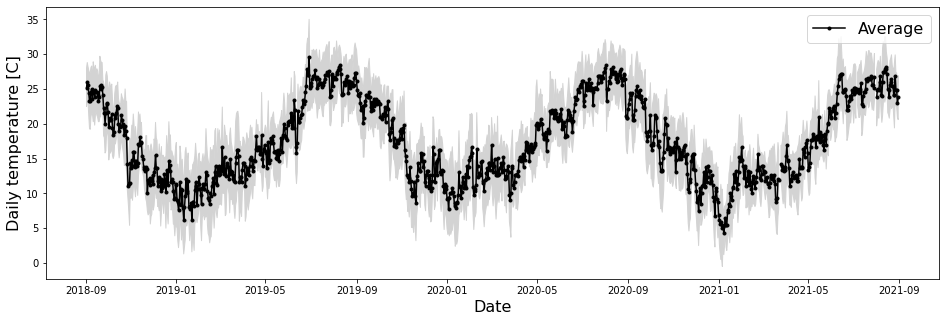

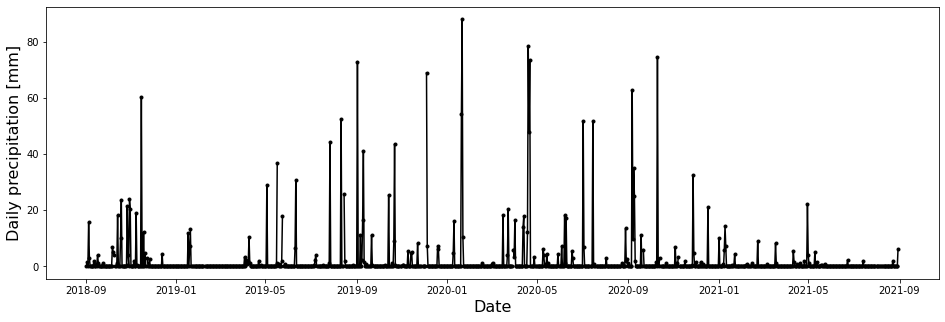

In [55]:
# Leave this code as-is

# Retrieve the last three years
weather_sample = weather.tail(3*365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precipitation [mm]")

As we can see in the first plot there is a kind of stationary sense in the daily temperature as expected, normally at the start of the day the temperature is higger but at noon and later in the night the temperature normally decrease. But with the daily precipitation we can not see clear a stationary as we expected, that is why it's often so difficult to predict.

## 1.1 Smooth the series using moving averages

In [56]:
def moving_average(df, window_size):
    cols = df.columns
    smoothed = pd.DataFrame(columns=df.columns)
    for i in range(len(df)):
        # YOUR CODE HERE
        values = []
        for column in df:
            if i <  window_size:
                values.append(np.mean(df[column].iloc[0:i+1]))
            else:
                values.append(np.mean(df[column].iloc[i-window_size:i]))
        smoothed = smoothed.append({col:values[i] for i,col in enumerate(cols)} ,ignore_index=True)
        
    smoothed.set_index(df.index, inplace=True)

    return smoothed



In [57]:
weather[cols].head(3)

,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max
date,,,,,,,,,,
2016-09-01,22.9,31.5,27.2,0.0,24.0,4.2,8.3,10.0,1020.1,1021.9
2016-09-02,22.2,29.2,25.7,0.0,23.0,5.3,11.7,9.9,1018.0,1021.3
2016-09-03,22.9,29.6,26.2,0.0,24.0,5.8,12.8,10.1,1017.0,1020.0


In [58]:
cols = ["temp_min","temp_max","temp_avg","rainfall"
           ,"windspeed_dir","windspeed_avg","windspeed_gusts",
          "sun","pressure_min","pressure_max"]
weather = weather[cols]
moving_average(weather, 1).head(3)

,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max
date,,,,,,,,,,
2016-09-01,22.9,31.5,27.2,0.0,24.0,4.2,8.3,10.0,1020.1,1021.9
2016-09-02,22.9,31.5,27.2,0.0,24.0,4.2,8.3,10.0,1020.1,1021.9
2016-09-03,22.2,29.2,25.7,0.0,23.0,5.3,11.7,9.9,1018.0,1021.3


In [59]:
moving_average(weather, 2).head(3)

,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max
date,,,,,,,,,,
2016-09-01,22.90,31.50,27.20,0.0,24.0,4.20,8.3,10.00,1020.10,1021.9
2016-09-02,22.55,30.35,26.45,0.0,23.5,4.75,10.0,9.95,1019.05,1021.6
2016-09-03,22.55,30.35,26.45,0.0,23.5,4.75,10.0,9.95,1019.05,1021.6


In [60]:
# Leave this code as-is

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max
date,,,,,,,,,,
2016-09-01,22.900000,31.500000,27.200000,0.000000,24.000000,4.200000,8.300000,10.000000,1020.100000,1021.900000
2016-09-02,22.550000,30.350000,26.450000,0.000000,23.500000,4.750000,10.000000,9.950000,1019.050000,1021.600000
2016-09-03,22.666667,30.100000,26.366667,0.000000,23.666667,5.100000,10.933333,10.000000,1018.366667,1021.066667
2016-09-04,22.725000,30.100000,26.400000,0.000000,42.500000,4.925000,10.900000,9.550000,1017.800000,1020.375000
2016-09-05,23.020000,30.400000,26.700000,0.000000,37.800000,4.560000,10.060000,9.740000,1017.620000,1020.060000
2016-09-06,23.050000,30.533333,26.783333,0.000000,48.000000,4.500000,9.683333,9.866667,1017.266667,1019.783333
2016-09-07,23.014286,30.328571,26.671429,0.000000,42.571429,4.414286,9.771429,9.985714,1016.957143,1019.414286
2016-09-08,23.014286,30.328571,26.671429,0.000000,42.571429,4.414286,9.771429,9.985714,1016.957143,1019.414286
2016-09-09,22.871429,29.842857,26.357143,0.000000,40.857143,4.371429,9.771429,9.628571,1016.128571,1018.628571


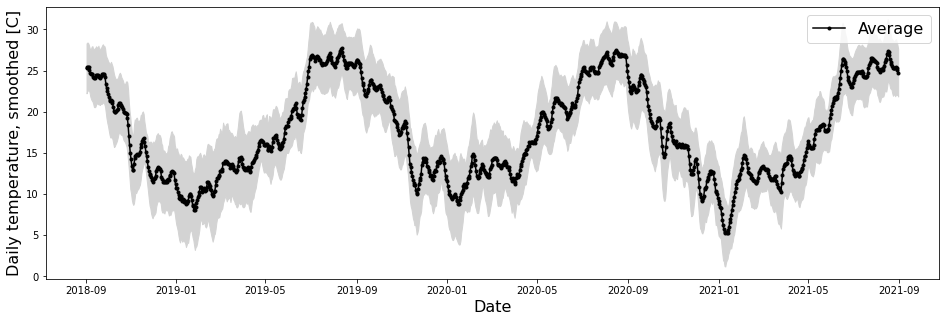

In [61]:
# Leave this code as-is

# Sample last 3 years
weather_smoothed_sample = weather_smoothed.tail(3*365)

plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

If the series are quite large implement may have a high computational cost because you have to make calculations for all the points, other thing is what window size use, because sometimes if you smooth too much you can loose information that can be relevant.

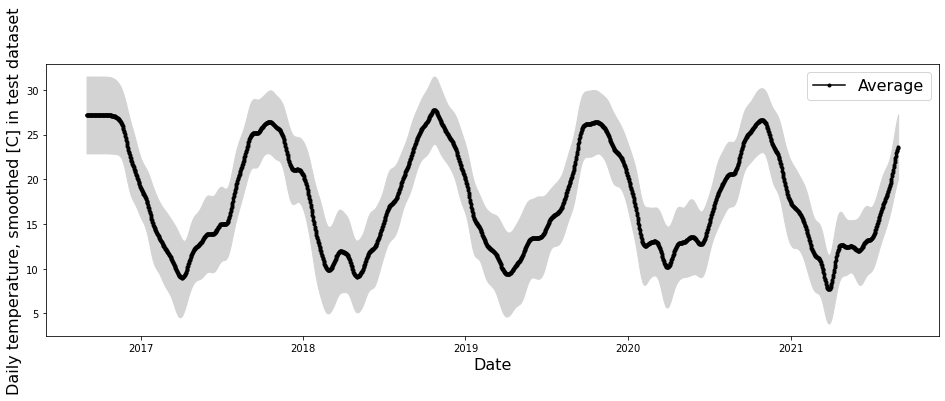

In [62]:
test = weather
for i in range(20):
    test = moving_average(test, window_size)
plot_min_avg_max(test, ylabel='Daily temperature, smoothed [C] in test dataset')

As we can see, if we apply a lot of consecutive smoths we are smoothing the serie but we are loosing information.

## 1.2. Smooth the series by binning per floating weeks

In [63]:
def list_of_floating_week_starts(first, last):
    weeks = []

    # YOUR CODE HERE
    element = first
    while element < last:
        weeks.append(element)
        element += datetime.timedelta(weeks=1)
    weeks.append(element+datetime.timedelta(weeks=1))
    return(weeks)

In [64]:
# Leave this code as-is

first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 262 week starts
First week starts 2016-09-01, last week starts 2021-09-09


In [65]:
# Leave this code as-is

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

/Users/josepmoncluscarrasco/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max,week_start
date,,,,,,,,,,,
2016-09-01,22.9,31.5,27.2,0.0,24.0,4.2,8.3,10.0,1020.1,1021.9,2016-09-01
2016-09-02,22.2,29.2,25.7,0.0,23.0,5.3,11.7,9.9,1018.0,1021.3,2016-09-01
2016-09-03,22.9,29.6,26.2,0.0,24.0,5.8,12.8,10.1,1017.0,1020.0,2016-09-01
2016-09-04,22.9,30.1,26.5,0.0,99.0,4.4,10.8,8.2,1016.1,1018.3,2016-09-01
2016-09-05,24.2,31.6,27.9,0.0,19.0,3.1,6.7,10.5,1016.9,1018.8,2016-09-01
2016-09-06,23.2,31.2,27.2,0.0,99.0,4.2,7.8,10.5,1015.5,1018.4,2016-09-01
2016-09-07,22.8,29.1,26.0,0.0,10.0,3.9,10.3,10.7,1015.1,1017.2,2016-09-01
2016-09-08,21.9,28.1,25.0,0.0,12.0,3.9,8.3,7.5,1014.3,1016.4,2016-09-08
2016-09-09,23.9,29.6,26.8,0.3,24.0,5.0,10.8,6.9,1013.0,1015.9,2016-09-08


In [66]:
weather_per_floating_week = weather_with_week_start.groupby("week_start").aggregate({'temp_min' : 'mean'
                                                         , 'temp_max' : 'mean'
                                                         ,'temp_avg' : 'mean',
                                                        'rainfall' : 'sum'})

weather_per_floating_week.head(10)

,temp_min,temp_max,temp_avg,rainfall
week_start,,,,
2016-09-01,23.014286,30.328571,26.671429,0.0
2016-09-08,20.671429,28.685714,24.685714,18.3
2016-09-15,16.585714,25.671429,21.157143,4.2
2016-09-22,17.885714,25.742857,21.814286,14.6
2016-09-29,18.157143,25.157143,21.642857,21.4
2016-10-06,15.285714,21.428571,18.357143,51.0
2016-10-13,14.928571,22.785714,18.828571,13.0
2016-10-20,16.085714,20.742857,18.428571,11.0
2016-10-27,13.771429,21.342857,17.557143,0.0


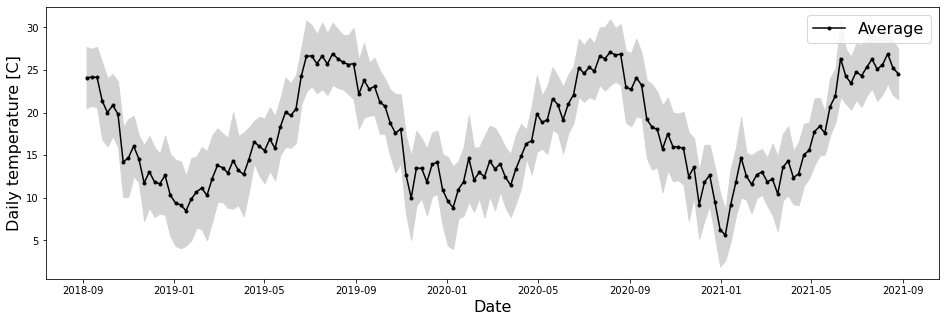

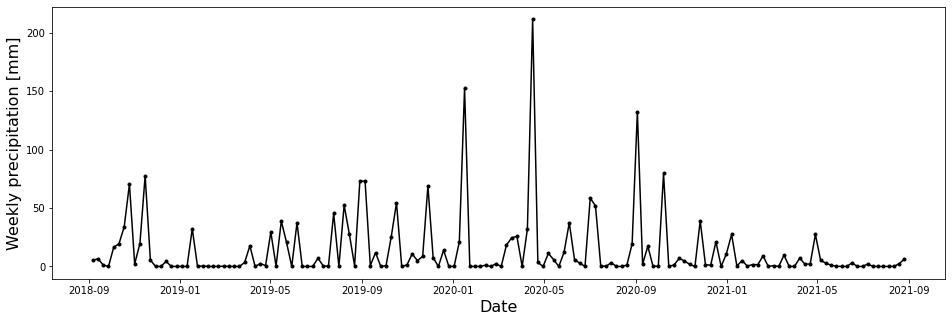

In [67]:
# Leave this code as-is

# Retrieve the past three years
weather_sample = weather_per_floating_week.tail(52*3)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precipitation [mm]")

As we can see in this plots the series are smothed, and we eliminate big part of the noise

## 1.3. Smooth the series by binning per month

In [68]:
def list_of_month_starts(first, last):
    months = []
    element = first.replace(day=1)
    while element <= last.replace(day=1):
        months.append(element)
        if element.month < 12:
            element = element.replace(month=element.month+1)
        else:
            element = element.replace(year=element.year+1, month=1)
    months.append(element)
    return(months)
    
    

In [69]:
# Leave this code as-is

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 61 month starts
First month starts 2016-09-01, last month starts 2021-09-01


In [70]:
# Leave this code as-is

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_min,temp_max,temp_avg,rainfall,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_min,pressure_max,week_start,month_start
date,,,,,,,,,,,,
2016-09-01,22.9,31.5,27.2,0.0,24.0,4.2,8.3,10.0,1020.1,1021.9,2016-09-01,2016-09-01
2016-09-02,22.2,29.2,25.7,0.0,23.0,5.3,11.7,9.9,1018.0,1021.3,2016-09-01,2016-09-01
2016-09-03,22.9,29.6,26.2,0.0,24.0,5.8,12.8,10.1,1017.0,1020.0,2016-09-01,2016-09-01
2016-09-04,22.9,30.1,26.5,0.0,99.0,4.4,10.8,8.2,1016.1,1018.3,2016-09-01,2016-09-01
2016-09-05,24.2,31.6,27.9,0.0,19.0,3.1,6.7,10.5,1016.9,1018.8,2016-09-01,2016-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,23.7,29.9,26.8,0.0,7.0,3.1,9.7,10.0,1010.1,1012.7,2021-08-26,2021-08-01
2021-08-28,22.6,27.2,24.9,0.0,11.0,4.7,9.2,5.7,1009.9,1014.6,2021-08-26,2021-08-01
2021-08-29,22.4,27.3,24.8,0.0,99.0,3.9,9.2,7.4,1012.6,1014.5,2021-08-26,2021-08-01


As before, aggregate per month to create a dataframe with averages of `temp_min`, `temp_avg`, and `temp_max` per month, and sum of `rainfall`.

 <font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to generate the "weather_per_month" dataframe</font>

In [71]:
weather_per_month = weather_with_month_start.groupby("month_start").aggregate({'temp_min' : 'mean'
                                                         , 'temp_max' : 'mean'
                                                         ,'temp_avg' : 'mean',
                                                        'rainfall' : 'sum'})

weather_per_month.head(10)

,temp_min,temp_max,temp_avg,rainfall
month_start,,,,
2016-09-01,19.363333,27.476667,23.426667,37.1
2016-10-01,15.712903,22.109677,18.906452,96.4
2016-11-01,10.186667,18.356667,14.283333,77.8
2016-12-01,7.093548,16.006452,11.551613,22.2
2017-01-01,4.853333,13.170000,9.010000,34.6
2017-02-01,8.760714,16.278571,12.521429,28.3
2017-03-01,9.450000,18.016667,13.723333,84.0
2017-04-01,10.560000,18.850000,14.713333,41.9
2017-05-01,15.553333,23.173333,19.356667,15.5


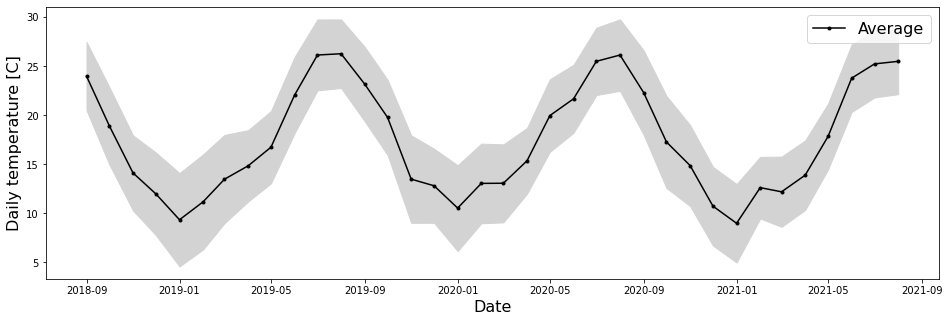

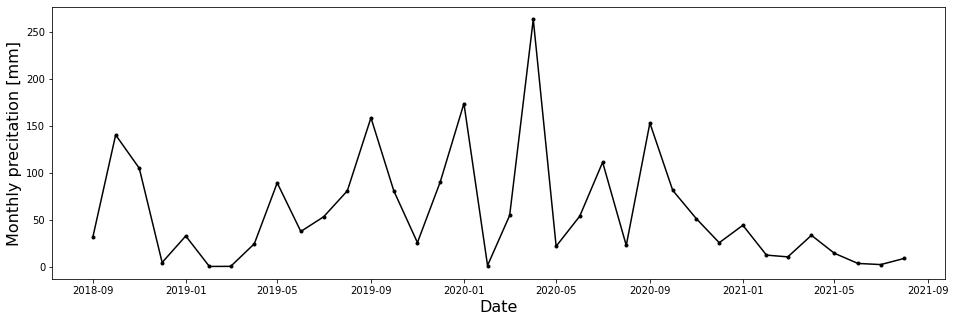

In [72]:
# Leave this code as-is

# Retrieve the last 3 years
weather_sample = weather_per_month.tail(3*12)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

We can observe that the temperatures more or less be repeated during the years, but the precipitation no

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

In [73]:
def lagged_series(series, lag):
    original = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        if j >= 0 and j <= len(series)-1:
            original.append(series[i])
            lagged.append(series[j])
        # but only if j is in [0, len(series)-1]
    return original, lagged

In [74]:
# Leave this code as-is

lagged_series([11,22,33,44,55,66,77,88], 3)

([44, 55, 66, 77, 88], [11, 22, 33, 44, 55])

In [75]:
# Leave this code as-is

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

In [76]:
def compute_autocorrelations(series,max_periods):
    autocorrelations = []
    for lag in range(max_periods):
        autocorrelations.append(autocorrelation(series, lag))
    return autocorrelations

In [77]:
auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], 2*365)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], 2*365)

In [78]:
# Leave this code as-is

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

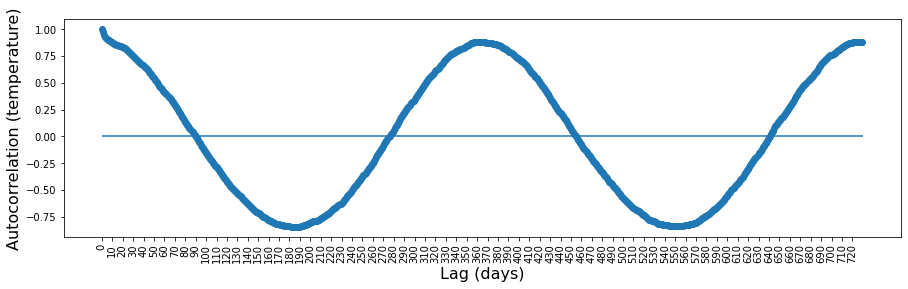

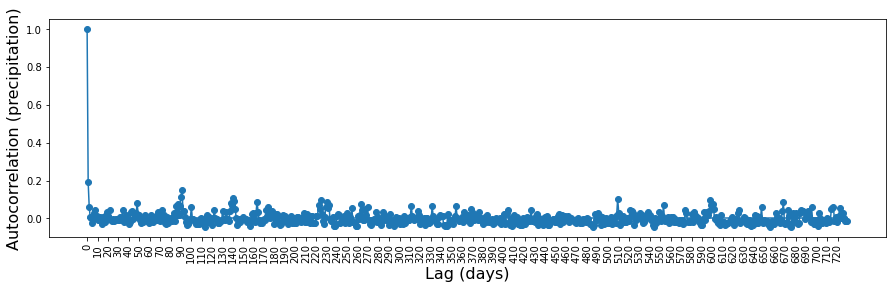

In [79]:
# Leave this code as-is

# Plot temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

I think in this plot we can see the high correlation on the temperature because of the stationarity, but no with the autocorrelation

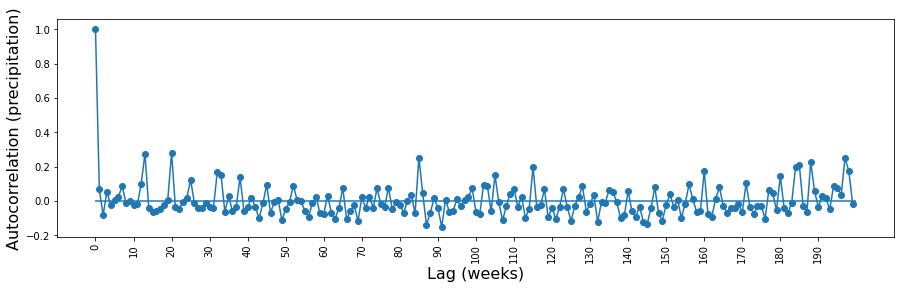

In [80]:
# Leave this code as-is

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

Seems sporious and not a real dependency

## 2.2. Prepare a system of equations to learn an auto-regressive model

In [81]:
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
        
    for i in range(np.max(lags), len(series)):
        # YOUR CODE HERE
        na = False
        row = []
        for lag in lags:
            if not math.isnan(series[i-lag]) or na:
                row.append(series[i-lag])
            else:
                na = True
        if not na and not math.isnan(series[i]):
            X.append(row)
            y.append(series[i])

    return X, y

In [82]:
# Leave this code as-is

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


In [83]:
# Leave this code as-is

X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


## 2.3. Perform forecasts

In [84]:
# Leave this code as-is

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='blue', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

In [85]:
lags_monthly_temperature = [1,3,7,30]

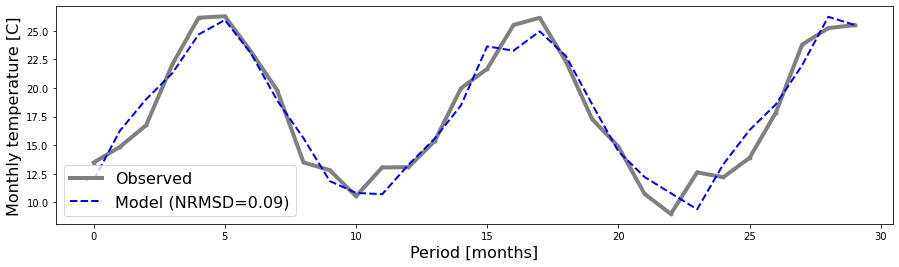

In [86]:
# Leave this code as-is

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

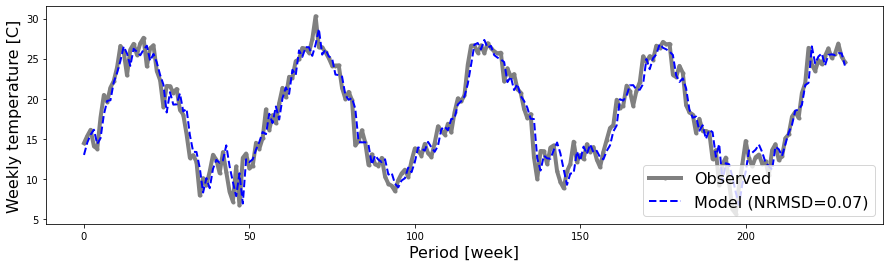

In [87]:
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [week]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

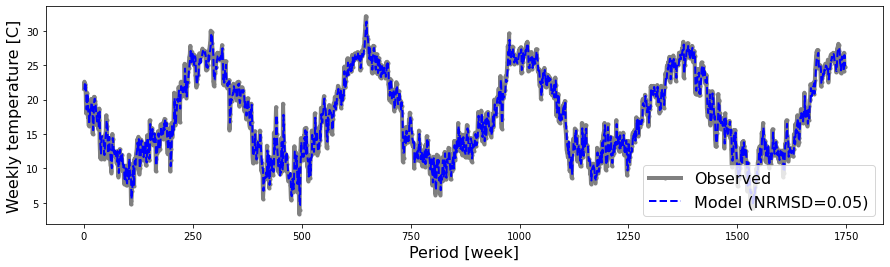

In [88]:
(y, y_pred, nrmsd) = perform_forecast(weather['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="daily temperature [C]", nrmsd=nrmsd)

As we can see, because of the stationarity we obtain quite good results predicting the temperature

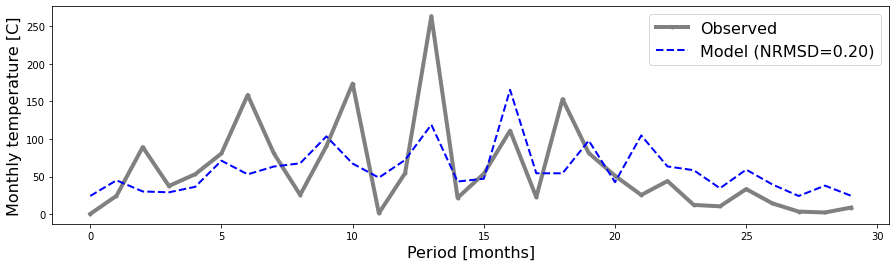

In [89]:
(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly rainfall", nrmsd=nrmsd)

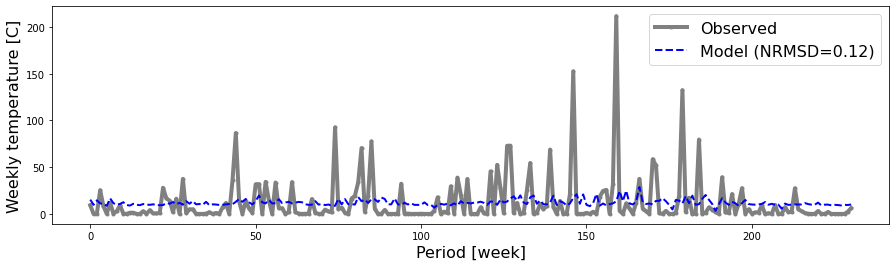

In [92]:
(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [week]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


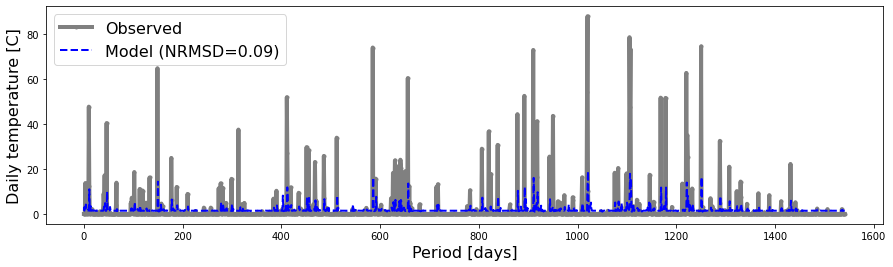

In [93]:
(y, y_pred, nrmsd) = perform_forecast(weather['rainfall'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)

Predict the rain fall is quite complicated, so we not obtain results that good as with the temperature, and as we can see all the fails that have our model is predicting the peaks, because is not normal day.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>